RNNs are a class of neural networks that allow previous outputs to be useed as inputs while having hidden states

to classify names to countries

In [2]:
import io
import os
import unicodedata
import string
import glob

import torch
import random

# utils

In [3]:
# alphabet small and capital lettes + " .,;"

ALL_LETTERS = string.ascii_letters + " .,;"
N_LETTERS = len(ALL_LETTERS)

In [4]:
# translate unicode string to plain ASCII

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

In [5]:
unicode_to_ascii(f"&^%*GHNCcghsdfdら为Romão")

'GHNCcghsdfdRomao'

In [6]:
def load_data():
    # build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []

    def find_files(path):
        return glob.glob(path)  # Return a list of paths matching a pathname pattern.
    
    # read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]

    for filename in find_files('data/data_rnn/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)

        lines = read_lines(filename)
        category_lines[category] = lines
    return category_lines, all_categories

In [7]:
names, categories = load_data()

In [8]:
# position of the letter in ALL_LETTERS
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

In [9]:
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

In [10]:
# Translate a line into a <ine_length x 1 x n_letters>,
# or an array of one-hot letter vectors

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

In [11]:
def random_training_example(category_lines, all_categories):
    
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

# RNN

In [12]:
import torch.nn as nn
import matplotlib.pyplot as plt

In [13]:
class RNN(nn.Module):
    # from scratch
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        # combine (concatenate) the input vector and hidden vector
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # input to hidden
        self.i2o = nn.Linear(input_size + hidden_size, output_size) # input to output
        self.softmax = nn.LogSoftmax(dim=1) # input shape: 1 x 57, take the second dim

    def forward(self, input_tensor, hidden_tensor):
        combined_tensor = torch.cat((input_tensor, hidden_tensor), 1)   # concactenate in dim=1

        hidden = self.i2h(combined_tensor)
        output = self.i2o(combined_tensor)
        output = self.softmax(output)
        return output, hidden
        
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
        

In [14]:
names_dict, categories = load_data()

In [15]:
n_categories = len(categories)


In [16]:
names_dict['Chinese'][:3], n_categories, categories[:3]

(['Ang', 'AuYong', 'Bai'], 18, ['Dutch', 'Polish', 'Arabic'])

In [17]:
device = torch.device('cuda')
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories).to(device)

In [20]:
# one step try

input_tensor = letter_to_tensor("A")
hidden_tensor = rnn.init_hidden()
input_tensor = input_tensor.to(device)
hidden_tensor = hidden_tensor.to(device)

In [21]:
output, next_hidden = rnn(input_tensor, hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [22]:
# whole seq/name

input_tensor = line_to_tensor("Yooko")
input_tensor = input_tensor.to(device)
hidden_tensor = rnn.init_hidden()
hidden_tensor = hidden_tensor.to(device)

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [23]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return categories[category_idx]

In [24]:
category_from_output(output)

'Chinese'

# train process

In [25]:
criterion = nn.NLLLoss()    # negative likelihoo loss fuc

learning_rate = 0.005

optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [27]:
# one training step

def train(line_tensor, category_tensor):
    line_tensor = line_tensor.to(device)
    category_tensor = category_tensor.to(device)
    
    hidden = rnn.init_hidden().to(device)

    for i in range(line_tensor.size()[0]):  # length of a name

        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

4999 4.9990 2.4812 Noguerra / Japanese WRONG (should be Spanish)
9999 9.9990 1.8439 Minami / Italian WRONG (should be Japanese)
14999 14.9990 2.3253 Jacques / Dutch WRONG (should be French)
19999 19.9990 2.1384 Favero / Portuguese WRONG (should be Italian)
24999 24.9990 1.9245 De santigo / Italian WRONG (should be Portuguese)
29999 29.9990 0.7111 Tong / Vietnamese CORRECT
34999 34.9990 0.7465 Nishiwaki / Polish WRONG (should be Japanese)
39999 39.9990 0.8964 Telis / Greek CORRECT
44999 44.9990 2.6750 Knowler / German WRONG (should be English)
49999 49.9990 0.1631 Tsujimoto / Japanese CORRECT
54999 54.9990 1.3239 Menendez / Spanish CORRECT
59999 59.9990 0.3762 Sfakianos / Greek CORRECT
64999 64.9990 0.5755 Sakelaris / Greek CORRECT
69999 69.9990 0.6016 Lichko / Russian CORRECT
74999 74.9990 2.7348 Sleiman / Irish WRONG (should be Arabic)
79999 79.9990 0.0524 Karnoupakis / Greek CORRECT
84999 84.9990 0.0044 Ishiyama / Japanese CORRECT
89999 89.9990 3.0512 Weigand / English WRONG (should 

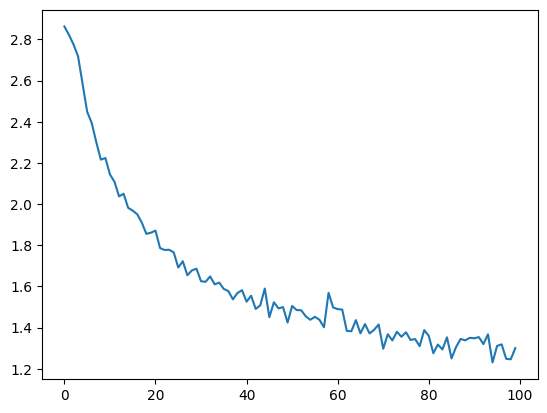

In [28]:
current_loss = 0.0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(names_dict, all_categories=categories)

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0.0

    if (i+1) % print_steps == 0:
        pred = category_from_output(output)
        correct = "CORRECT" if pred == category else f"WRONG (should be {category})"
        print(f"{i} {i / n_iters*100:.4f} {loss:.4f} {line} / {pred} {correct}")



plt.figure()
plt.plot(all_losses)
plt.show()

In [31]:
# predict an input

def predict(input_line):
    print(f"\n > {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line).to(device)
        hidden = rnn.init_hidden().to(device)

        for i in range(line_tensor.size()[0]):  # length of a name
            output, hidden = rnn(line_tensor[i], hidden)

        pred = category_from_output(output)
        print(f"{pred}")

while True:
    sentence = input("Input:")
    if sentence == "quit":
        break

    predict(sentence)


 > Santa
Czech

 > Sam
Korean

 > Kim
Korean

 > Jack
Korean

 > Sung
Chinese

 > Kinstov
Russian

 > Patrick
Czech

 > Jerry
English

 > Adam
Irish
